# MICOM analysis

In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os
import yaml

import pandas as pd

from micom import Community

from biofoundry.data.amils2023 import Amils2023DataLoader
from biofoundry.micom import MICOMPreloader, plot_abundances_depth
from biofoundry.utils import save_fig

In [3]:
# Load config

with open("../biofoundry/config.yml") as config_file:
    config = yaml.safe_load(config_file)

In [4]:
output_dir = os.path.join(
    config["paths"]["micom"],
    "amils2023"
)

data_loader = Amils2023DataLoader()
preloader = MICOMPreloader(config)

In [5]:
abundances_df = data_loader.get_abundances()
abundances_df

/Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/filiberto/git/astrobio/tfm/mars-biofoundry/notebooks/../biofoundry/data/amils2023/data_loader.py:397: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()
/Users/filiberto/git/astrobio/tfm/mars-biofoundry/notebooks/../biofoundry/data/amils2023/data_loader.py:400: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()


,genus,sample_id,abundance
0,Acidiphilium,BH10-103-Illumina,0.0
1,Aciditerrimonas,BH10-103-Illumina,0.0
2,Acidovorax,BH10-103-Illumina,0.0
3,Acinetobacter,BH10-103-Illumina,0.0
4,Actinobacillus,BH10-103-Illumina,0.0
...,...,...,...
1031,Spirosoma,BH10-496-Roche,0.0
1032,Truepera,BH10-496-Roche,0.0
1033,WPS-1_genera_incertae_sedis,BH10-496-Roche,0.0
1034,Xylanimicrobium,BH10-496-Roche,0.0


In [6]:
metadata_df = pd.read_csv(
    os.path.join(
        config["paths"]["genomes"],
        "genomes-metadata.csv"
    )
)

taxonomy_df = preloader.get_taxonomy(metadata_df)
taxonomy_df

,id,genus,species,reactions,metabolites,file
0,aci,Acidovorax,Acidovorax BoFeN1,1246,1199,../data/gem/aci_formatted.json
1,bme,Brevundimonas,Brevundimonas sp. T2.26MG-97,431,460,../data/gem/bme_formatted.json
2,dmi,Desulfosporosinus,Desulfosporosinus meridiei DEEP,1157,1104,../data/gem/dmi_formatted.json
3,pse,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json
4,rhi1,Rhizobium,Rhizobium sp. T2.30D-1.1,712,797,../data/gem/rhi1_formatted.json
5,rhi2,Rhizobium,Rhizobium sp. T2.26MG-112.2,683,773,../data/gem/rhi2_formatted.json
6,rho,Rhodoplanes,Rhodoplanes sp. T2.26MG-98,442,490,../data/gem/rho_formatted.json
7,shw,Shewanella,Shewanella sp. T2.3D-1.1,1324,1193,../data/gem/shw_formatted.json
8,tel,Tessaracoccus,Tessaracoccus lapidicaptus IPBSL-7,1199,1111,../data/gem/tel_formatted.json
9,tez,Tessaracoccus,Tessaracoccus sp. T2.5-30,1197,1114,../data/gem/tez_formatted.json


### Combining taxonomy and abundances

In [7]:
# TODO: divide counts for Tessaracoccus and Rhizobium!!!
taxonomy_abundances = pd.merge(
    left=taxonomy_df,
    right=abundances_df,
    on="genus",
    how="left"
)

# Combine ID column with sample ID to avoid errors in MICOM due to ID duplicates
taxonomy_abundances["id"] = \
    taxonomy_abundances["id"] + "_" + taxonomy_abundances["sample_id"]

print(
    "[WARNING] Species for which there are no abundance data:\n",
    taxonomy_abundances[taxonomy_abundances["id"].isnull()]["species"].values
)

# Save to file
taxonomy_abundances.to_csv(
    os.path.join(
        output_dir,
        "taxonomy.csv"
    ),
    header=True,
    index=False,
    sep=","
)

[WARNING] Species for which there are no abundance data:
 ['Brevundimonas sp. T2.26MG-97' 'Desulfosporosinus meridiei DEEP'
 'Rhodoplanes sp. T2.26MG-98' 'Shewanella sp. T2.3D-1.1']


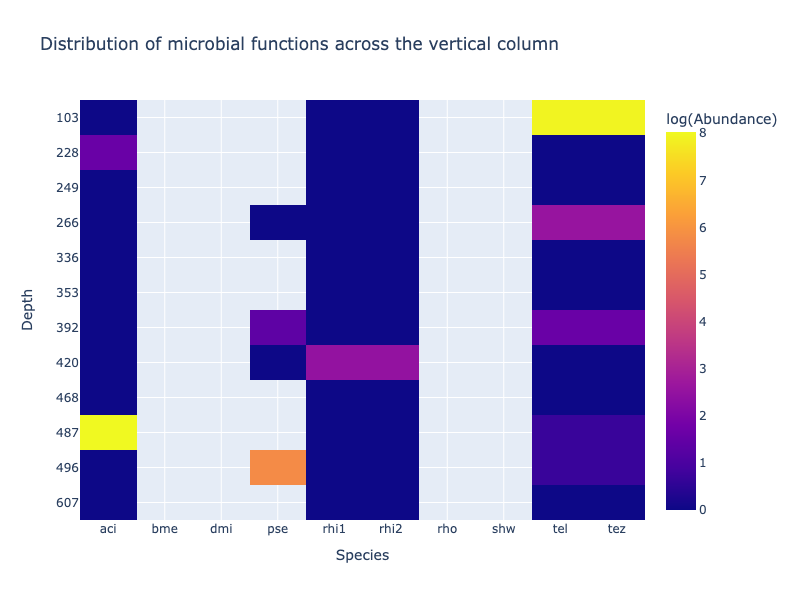

In [8]:
fig = plot_abundances_depth(taxonomy_abundances)
fig.show("png")

save_fig(
    fig=fig,
    filename="abundances-depth.jpg",
    config=config
)

In [9]:
%%script false --no-raise-error

# Build community
com = Community(taxonomy_abundances)

# Save community
com.to_pickle(
    os.path.join(
        output_dir,
        "community.pickle"
    )
)

# Get tradeoffs
sol = com.cooperative_tradeoff()

# Experiments

#### Same abundance among species

* Objective: community growth
* Objective: community growth + production of metabolite of interest
* Objective: community growth + production of metabolite of interest + anaerobic conditions

#### Use abundances from Amils et al. 2023

* A community model for each depth
* A community model merging the maximum at all depths